<a href="https://colab.research.google.com/github/Kaya-P/work/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Welcome to **Beating The Odds**. In this project we are looking to see if we can build models to perform better than current betting agencies. We have a dataset with matches played in Europe alongside the outcomes the betting agencies gave for each game. Additionally

# **Setup Context**

**In this section we download the necessary packages, import tools, and initialize pyspark**

In [ ]:
#download all the necessary packages
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 34 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates

In [ ]:
!apt update
!apt install gcc python-dev libkrb5-dev

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bi

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('fnl').getOrCreate()

In [ ]:
import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3

# **Download Data**

**In this section we converted the sqlite database we had downloaded from kaggle into panda dataframes so we could save them as CSVs.** Thus, this section only needed to be run once to create our initial CSVs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# convert sqlite data from kaggel to csv to store and reuse as we build our project
!unzip "/content/drive/Shareddrives/FinalProject_545/soccer.zip"

Archive:  /content/drive/Shareddrives/FinalProject_545/soccer.zip
  inflating: database.sqlite         


In [ ]:
# convert sqlite data from kaggel to csv to store and reuse as we build our project
# there were seven tables of data in the sqlite file. We extracted all seven 
# and saved them in our project folder to use for the rest of our project.
con = sqlite3.connect("database.sqlite")
tables = ['Country', 'League', 'Team', 'Player', 'Player_Attributes', 'Team_Attributes']

for t in tables:
  data = pd.read_sql_query("SELECT * FROM {}".format(t) ,con)
  data.to_csv('/content/drive/Shareddrives/FinalProject_545/'+t+'.csv')


# **Clean Data**

**In this section we clean our data and save clean CSVs in preparation for our EDA and Modelling.** We dropped columns with too many nulls that we deemed were not too important and dropped records that contained any null values in them. Thus, our clean data was complete.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We knew that we wanted to use the data to predict wins so we dropped most the columns that could only be filled with data after the match is completed. Additionally, we found that betting agencies have minimal variance between them during our EDA and came back to drop betting agencies which had too many null records. 

In [ ]:
match_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Match.csv")

print('Match')
match_sdf.select([F.count(F.when((F.isnan(c))|(F.isnull(c)),c)).alias(c) for c in match_sdf.columns]).show()

match_drops = ['_c0', 'goal', 'shoton', 'shotoff', 'foulcommit', 
               'card', 'cross', 'corner', 'possession',
               'PSH', 'PSD', 'PSA', 'SJH', 'SJD', 'SJA', 
               'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']
clean_match_sdf = match_sdf.drop(*match_drops)

na_drops = ['home_player_1', 'home_player_2', 'home_player_3',
            'home_player_4', 'home_player_5', 'home_player_6',
            'home_player_7', 'home_player_8', 'home_player_9',
            'home_player_10', 'home_player_11', 
            'away_player_1', 
            'away_player_2','away_player_3','away_player_4',
            'away_player_5','away_player_6','away_player_7',
            'away_player_8','away_player_9','away_player_10',
            'away_player_11',
            'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 
            'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 
            'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA',
            'IWH', 'IWD', 'IWA']
clean_match_sdf = clean_match_sdf.na.drop(subset=na_drops)

clean_match_sdf = clean_match_sdf.dropna()

clean_df = clean_match_sdf.toPandas()
clean_df.to_csv('Clean_Match.csv')
!cp Clean_Match.csv "/content/drive/Shareddrives/FinalProject_545/"

Match
+---+----+----------+---------+------+-----+----+------------+----------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--

In [ ]:
player_attr_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Player_Attributes.csv")

print('Team_Attr')
player_attr_sdf.select([F.count(F.when((F.isnan(c))|(F.isnull(c)),c)).alias(c) for c in player_attr_sdf.columns]).show()

drop_columns = ['_c0', 'attacking_work_rate', 'volleys', 'curve', 'agility', 'balance',
                'jumping', 'vision', 'sliding_tackle']
clean_attr_sdf = player_attr_sdf.drop(*drop_columns)
clean_attr_sdf = clean_attr_sdf.na.drop()

clean_df = clean_attr_sdf.toPandas()
clean_df.to_csv('Clean_Player_Multi_Atts.csv')
!cp Clean_Player_Multi_Atts.csv "/content/drive/Shareddrives/FinalProject_545/"

Team_Attr
+---+---+------------------+-------------+----+--------------+---------+--------------+-------------------+-------------------+--------+---------+----------------+-------------+-------+---------+-----+------------------+------------+------------+------------+------------+-------+---------+-------+----------+-------+-------+--------+----------+----------+-------------+-----------+------+---------+-------+---------------+--------------+---------+-----------+----------+--------------+-----------+
|_c0| id|player_fifa_api_id|player_api_id|date|overall_rating|potential|preferred_foot|attacking_work_rate|defensive_work_rate|crossing|finishing|heading_accuracy|short_passing|volleys|dribbling|curve|free_kick_accuracy|long_passing|ball_control|acceleration|sprint_speed|agility|reactions|balance|shot_power|jumping|stamina|strength|long_shots|aggression|interceptions|positioning|vision|penalties|marking|standing_tackle|sliding_tackle|gk_diving|gk_handling|gk_kicking|gk_positioning|gk_re

In [ ]:
clean_attr_sdf = clean_attr_sdf.groupBy('player_api_id').agg({'overall_rating':'avg', 'potential':'avg',
                                               'crossing':'avg', 'finishing':'avg',   
                                               'heading_accuracy':'avg', 'short_passing':'avg',  
                                               'dribbling':'avg', 'free_kick_accuracy':'avg',
                                               'long_passing':'avg', 'ball_control':'avg',
                                               'acceleration':'avg', 'sprint_speed':'avg',
                                               'reactions':'avg', 'shot_power':'avg',  
                                               'stamina':'avg', 'strength':'avg',  
                                               'long_shots':'avg', 'aggression':'avg',   
                                               'interceptions':'avg', 'positioning':'avg',
                                               'penalties':'avg',  
                                               'marking':'avg', 'standing_tackle':'avg',
                                               'gk_diving':'avg', 'gk_handling':'avg', 
                                               'gk_kicking':'avg','gk_positioning':'avg', 
                                               'gk_reflexes':'avg', 
                                               })

clean_df = clean_attr_sdf.toPandas()
clean_df.to_csv('Clean_Player_Attributes.csv')
!cp Clean_Player_Attributes.csv "/content/drive/Shareddrives/FinalProject_545/"

In [ ]:
team_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Team.csv")

drop_columns = ['_c0', 'team_fifa_api_id', 'team_short_name']

clean_team_sdf = team_sdf.drop(*drop_columns)

clean_df = clean_team_sdf.toPandas()
clean_df.to_csv('Clean_Team.csv')
!cp Clean_Team.csv "/content/drive/Shareddrives/FinalProject_545/"

In [ ]:
team_atts_sdf = spark.read.options(header='True', inferSchema='True').csv('/content/drive/Shareddrives/FinalProject_545/Team_Attributes.csv')

drop_columns = ['_c0', 'buildUpPlayDribbling']

clean_team_atts_sdf = team_atts_sdf.drop(*drop_columns)

clean_df = clean_team_atts_sdf.toPandas()
clean_df.to_csv('Clean_Team_Attributes.csv')
!cp Clean_Team_Attributes.csv "/content/drive/Shareddrives/FinalProject_545/"

# **EDA**

**In this section we explore our data and investigate whether there are interesting relations we can utilize for our modeling.**

In [ ]:
# mount our google drive so we can access the data we need for this project. The data is stored in csv files.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We have 8 relevant csv files the have been cleaned. 
country_sdf = spark.read.options(header='True', inferSchema='True').csv('/content/drive/Shareddrives/FinalProject_545/Country.csv').drop('_c0')
league_sdf = spark.read.options(header='True', inferSchema='True').csv('/content/drive/Shareddrives/FinalProject_545/League.csv').drop('_c0')
match_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Match.csv").drop('_c0')
player_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Player.csv").drop('_c0')
player_attr_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Player_Attributes.csv").drop('_c0')
player_multi_attr_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Player_Multi_Atts.csv").drop('_c0')
team_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Team.csv").drop('_c0')
team_attr_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Team_Attributes.csv").drop('_c0')

## Player EDA

In our exploration of the datasets we are working with, we plotted the age distribution of the players. We found that most players are in their early thirties with most players being younger than that and very few players over 45.

Text(0.5, 1.0, 'Number of Players at each Age')

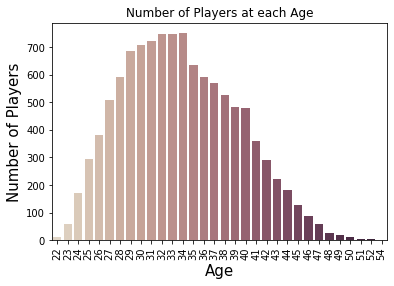

In [ ]:
player_sdf = player_sdf.withColumn('Age', F.datediff(F.current_date(), player_sdf.birthday))
player_sdf = player_sdf.withColumn("Age", F.floor(player_sdf.Age / 365)) 
player_df = player_sdf.select("*").toPandas()

ax = sns.countplot(x="Age",data=player_df, palette="ch:.25")
for label in ax.get_xticklabels():
        label.set_rotation(90)
ax.set_ylabel("Number of Players", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
ax.set_title('Number of Players at each Age')

The players who make up the team are critical to the teams success. To deepen our understanding of the properties of the players we ploted a heat map of the correlations of the properties of the players. 

[]

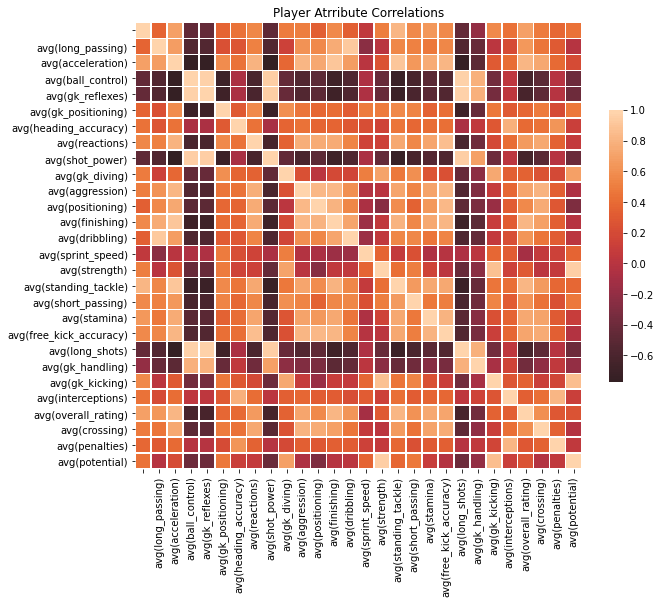

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

attr_sdf = player_attr_sdf
columns_to_drop = ['_c0']
attr_sdf = player_attr_sdf.drop(*columns_to_drop)

attr_sdf = attr_sdf.drop("player_api_id")

cols = attr_sdf.columns

myGraph = attr_sdf

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(myGraph).select(vector_col)


matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corrmatrix, vmax=1, center=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(['']+cols, rotation = 90)
ax.set_yticklabels(['']+cols, rotation = 0)
ax.set_title('Player Atrribute Correlations')
ax.plot()

Some of the trends we see are here that have a strong positive correlation between ball contorl and long shots, potential rating and strength and passing and dribbling. We also see negative correlation between shot power and reactions and, shot power and overall rating.

We also decided to illustrate these relationships in scatter plots and barplots of a variable. We see how strong thee correlations more visually. What we see is that the positve correlations have strong relationship than the negative ones. 

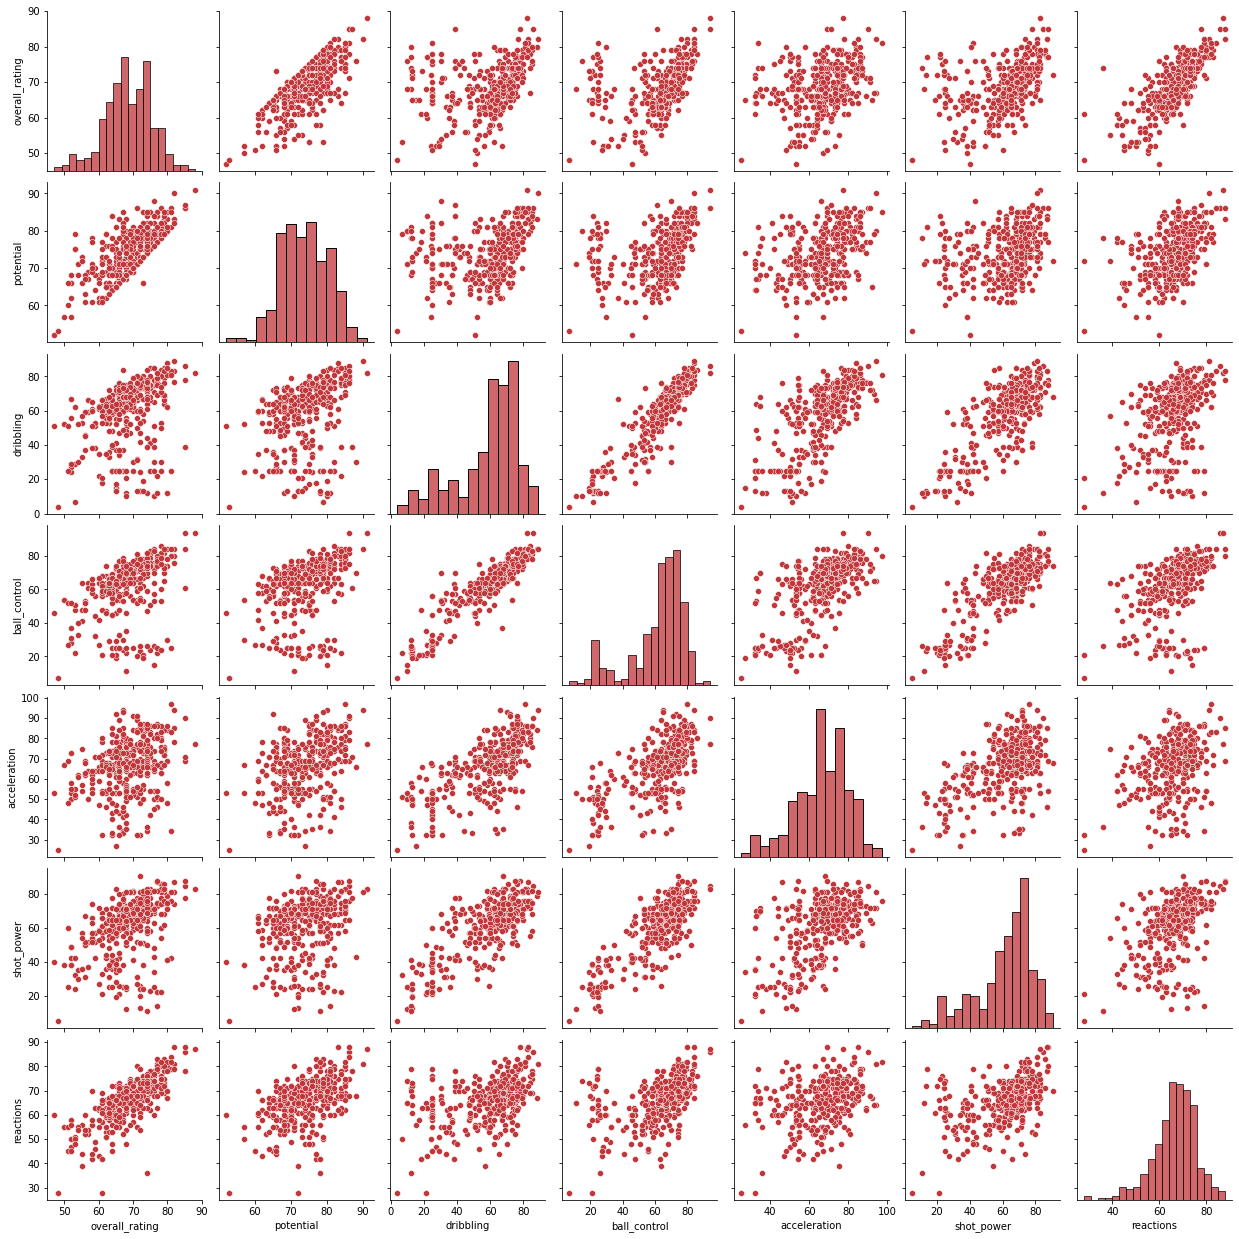

In [ ]:
values_attr_sdf = player_multi_attr_sdf

y_sdf = values_attr_sdf.select( 'overall_rating', 'potential',  
                   'dribbling', 'ball_control','acceleration', 
                    'shot_power','reactions')
data = y_sdf.sample(0.002,123).collect()
rdd = spark.sparkContext.parallelize(data)

df=rdd.toDF()

result_y_df = df.select("*").toPandas()

# Try some of these and pick your fave: ["Reds", "Reds_r", "RdGy", "hot", "Oranges", "Oranges_r", "autumn"]
sns.set_palette("RdGy")
sns.pairplot(result_y_df)
plt.show()

## Match EDA

### League Tables

We decided to first plot standard league tables to get a sense of the data available to us. These league tables revealed the dominant teams by each country's league, we also found that some teams play far more games than others.

In [ ]:
#Drop columns we would not use when constructing our league table
drop_columns = ['id', 'country_id', 'season', 'stage', 'date', 'match_api_id',
                'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4',
                'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8',
                'home_player_X9', 'home_player_X10', 'home_player_X11',
                'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4',
                'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8',
                'away_player_X9', 'away_player_X10', 'away_player_X11',
                'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
                'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8',
                'home_player_Y9', 'home_player_Y10', 'home_player_Y11',
                'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
                'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
                'away_player_Y9', 'away_player_Y10', 'away_player_Y11',
                'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
                'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
                'home_player_9', 'home_player_10','home_player_11',
                'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
                'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
                'away_player_9', 'away_player_10', 'away_player_11',
                'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 
                'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA']

match_league_sdf = match_sdf.drop(*drop_columns)

In [ ]:
#Temporarily split our matches between home and away to count how many times each team won, lost or or drew a game
home_league_sdf = match_league_sdf.withColumn(
    'Won', 
    F.when( (match_sdf['home_team_goal']  > match_sdf['away_team_goal']) , 1)
    .otherwise(0))

home_league_sdf = home_league_sdf.withColumn(
    'Drawn', 
    F.when( (match_sdf['home_team_goal']  == match_sdf['away_team_goal']) , 1)
    .otherwise(0))

home_league_sdf = home_league_sdf.withColumn(
    'Lost', 
    F.when( (match_sdf['home_team_goal']  < match_sdf['away_team_goal']) , 1)
    .otherwise(0))

home_league_sdf = home_league_sdf.withColumnRenamed('home_team_api_id', 'team_id').withColumnRenamed('home_team_goal', 'GF').withColumnRenamed('away_team_goal', 'GA')
home_league_sdf = home_league_sdf.drop(*['away_team_api_id', 'away_team_goal'])

home_league_sdf = home_league_sdf.select('league_id', 'team_id', 'Won', 'Drawn', 'Lost', 'GF', 'GA')

away_league_sdf = match_league_sdf.withColumn(
    'Won', 
    F.when( (match_sdf['home_team_goal']  < match_sdf['away_team_goal']) , 1)
    .otherwise(0))

away_league_sdf = away_league_sdf.withColumn(
    'Drawn', 
    F.when( (match_sdf['home_team_goal']  == match_sdf['away_team_goal']) , 1)
    .otherwise(0))

away_league_sdf = away_league_sdf.withColumn(
    'Lost', 
    F.when( (match_sdf['home_team_goal']  > match_sdf['away_team_goal']) , 1)
    .otherwise(0))

away_league_sdf = away_league_sdf.withColumnRenamed('away_team_api_id', 'team_id').withColumnRenamed('away_team_goal', 'GF').withColumnRenamed('home_team_goal', 'GA')
away_league_sdf = away_league_sdf.drop(*['home_team_api_id', 'home_team_goal'])

away_league_sdf = away_league_sdf.select('league_id', 'team_id', 'Won', 'Drawn', 'Lost', 'GF', 'GA')

In [ ]:
#comibined home and away and aggregated by team_id to view the teams performance across all their games
#added columns for team names, goal difference and the points they had based on their performance
match_league_sdf = home_league_sdf.union(away_league_sdf)

match_league_sdf = match_league_sdf.groupBy("team_id").agg(
    F.max("league_id").alias("league_id"),
    F.count("team_id").alias("MP"),
    F.sum("Won").alias("Won"),
    F.sum("Lost").alias("Lost"),
    F.sum("Drawn").alias("Drawn"),
    F.sum("GF").alias("GF"),
    F.sum("GA").alias("GA")
    )

match_league_sdf = match_league_sdf.withColumn(
    'GD', 
    (match_league_sdf['GF'] - match_league_sdf['GA']))

match_league_sdf = match_league_sdf.withColumn(
    'Pts', 
    (match_league_sdf['Won'] * 3 + match_league_sdf['Drawn']))

match_league_sdf = match_league_sdf.alias("match").join(
    team_sdf.alias("team"), (F.col("match.team_id") == F.col("team.team_api_id")),
    "left").withColumnRenamed("team_long_name", "team")

columns_to_drop = ["team_id", "id", "team_api_id","team_fifa_api_id"]
match_league_sdf = match_league_sdf.drop(*columns_to_drop)

match_league_sdf = match_league_sdf.select(
    'league_id', 'team', 'MP', 'Won', 'Lost', 'Drawn', 'GF', 'GA', 'GD', 'Pts')

match_league_sdf = match_league_sdf.sort(F.col('Pts').desc())

In [ ]:
#Show top 20 teams in Europe
match_league_sdf.show()

+---------+-------------------+---+---+----+-----+---+---+---+---+
|league_id|               team| MP|Won|Lost|Drawn| GF| GA| GD|Pts|
+---------+-------------------+---+---+----+-----+---+---+---+---+
|    21518|       FC Barcelona|270|209|  23|   38|754|206|548|665|
|    21518|     Real Madrid CF|282|209|  39|   34|782|289|493|661|
|    19694|             Celtic|273|197|  33|   43|624|202|422|634|
|     7809|   FC Bayern Munich|269|192|  34|   43|648|207|441|619|
|     1729|  Manchester United|299|187|  55|   57|569|276|293|618|
|    10257|           Juventus|285|178|  45|   62|511|235|276|596|
|     1729|            Chelsea|300|172|  58|   70|575|284|291|586|
|     4769|Paris Saint-Germain|295|169|  52|   74|547|256|291|581|
|     1729|            Arsenal|299|166|  61|   72|561|316|245|570|
|     1729|    Manchester City|291|166|  66|   59|571|290|281|557|
|    13274|               Ajax|235|158|  25|   52|564|202|362|526|
|    21518|    Atlético Madrid|284|156|  71|   57|481|287|194|

In [ ]:
#split match into its relevant leagues
belgium_sdf = match_league_sdf.where(F.col('league_id') == 1).drop('league_id')
england_sdf = match_league_sdf.where(F.col('league_id') == 1729).drop('league_id')
france_sdf = match_league_sdf.where(F.col('league_id') == 4769).drop('league_id')
germany_sdf = match_league_sdf.where(F.col('league_id') == 7809).drop('league_id')
italy_sdf = match_league_sdf.where(F.col('league_id') == 10257).drop('league_id')
netherlands_sdf = match_league_sdf.where(F.col('league_id') == 13274).drop('league_id')
portugal_sdf = match_league_sdf.where(F.col('league_id') == 17642).drop('league_id')
scotalnd_sdf = match_league_sdf.where(F.col('league_id') == 19694).drop('league_id')
spain_sdf = match_league_sdf.where(F.col('league_id') == 21518).drop('league_id')

In [ ]:
#Show top 20 teams by country
names = ['Belgium', 'England', 'France', 'Germany', 'Italy', 'Netherlands', 'Portugal', 'Scotland', 'Spain']
leagues = [belgium_sdf, england_sdf, france_sdf, germany_sdf, italy_sdf, netherlands_sdf, portugal_sdf, scotalnd_sdf, spain_sdf]
for i in range(len(leagues)):
  print(names[i])
  leagues[i].show()

Belgium
+--------------------+---+---+----+-----+---+---+---+---+
|                team| MP|Won|Lost|Drawn| GF| GA| GD|Pts|
+--------------------+---+---+----+-----+---+---+---+---+
|      RSC Anderlecht|167|105|  21|   41|328|145|183|356|
|      Club Brugge KV|165| 93|  39|   33|331|196|135|312|
|            KAA Gent|157| 77|  39|   41|274|180| 94|272|
|            KRC Genk|154| 70|  41|   43|254|178| 76|253|
|   Standard de Liège|160| 71|  56|   33|235|208| 27|246|
|         KV Kortrijk|152| 59|  61|   32|195|188|  7|209|
|    SV Zulte-Waregem|154| 52|  57|   45|216|214|  2|201|
|         KV Mechelen|152| 54|  60|   38|199|219|-20|200|
|    Sporting Lokeren|138| 49|  49|   40|187|192| -5|187|
|   KSV Cercle Brugge|135| 38|  70|   27|147|207|-60|141|
|  Sporting Charleroi| 95| 35|  38|   22|112|120| -8|127|
|        KVC Westerlo|114| 30|  53|   31|141|206|-65|121|
|        Beerschot AC| 96| 24|  47|   25|107|166|-59| 97|
|         KV Oostende| 59| 24|  23|   12| 91| 93| -2| 84|
|    W

### Home V Away

First we dropped columns from our Match dataset that would not be useful for what we are trying to see. This included information about the players position on the field, the players id and certain properties of the match such as number of corners and goals. 

In [ ]:
columns_to_drop = ['home_player_X1', 'home_player_X2', 'home_player_X3',
                   'home_player_X4', 'home_player_X5', 'home_player_X6',
                   'home_player_X7', 'home_player_X8', 'home_player_X9',
                   'home_player_X10', 'home_player_X11', 
                   'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
                   'home_player_Y4', 'home_player_Y5', 'home_player_Y6',
                   'home_player_Y7', 'home_player_Y8', 'home_player_Y9',
                   'home_player_Y10', 'home_player_Y11', 
                   'away_player_X1', 
                   'away_player_X2','away_player_X3','away_player_X4',
                   'away_player_X5','away_player_X6','away_player_X7',
                   'away_player_X8','away_player_X9','away_player_X10',
                   'away_player_X11',
                   'away_player_Y1','away_player_Y2', 'away_player_Y3',
                   'away_player_Y4','away_player_Y5','away_player_Y6',
                   'away_player_Y7','away_player_Y8','away_player_Y9',
                   'away_player_Y10','away_player_Y11',
                   'home_player_1', 'home_player_2', 'home_player_3',
                   'home_player_4', 'home_player_5', 'home_player_6',
                   'home_player_7', 'home_player_8', 'home_player_9',
                   'home_player_10', 'home_player_11', 
                   'away_player_1', 
                   'away_player_2','away_player_3','away_player_4',
                   'away_player_5','away_player_6','away_player_7',
                   'away_player_8','away_player_9','away_player_10',
                   'away_player_11',
                   'goal', 'shoton', 'shotoff', 'foulcommit','card', 'cross',
                   'corner','possession'
                   ]
result_match_sdf = match_sdf.drop(*columns_to_drop)

result_match_sdf = match_sdf.na.drop()

We then found the names of the teams corresponding with the home and away team ids and joined that information. We also removed the id's since having two columns representing the same information here would be redundant.

In [ ]:
result_sdf = result_match_sdf.alias("match").join(
    team_sdf.alias("team"), (F.col("match.home_team_api_id") == F.col("team.team_api_id")),
    "left")


result_sdf = result_sdf.withColumnRenamed("team_api_id","home_id")\
           .withColumnRenamed("team_fifa_api_id","home_fifa_id")\
           .withColumnRenamed("team_long_name","home_team_name")
 
 
result_sdf = result_sdf.alias("result").join(
    team_sdf.alias("team"), (F.col("result.away_team_api_id") == F.col("team.team_api_id")),
    "left")

result_sdf = result_sdf.withColumnRenamed("team_api_id","away_id")\
           .withColumnRenamed("team_fifa_api_id","away_fifa_id")\
           .withColumnRenamed("team_long_name","away_team_name")

columns_to_drop = ['_c0', 'id', 'away_id', 'home_id','home_fifa_id', 'away_fifa_id' ]
result_sdf = result_sdf.drop(*columns_to_drop)


Considering our model will try predict who will win a given game, it is important to understand who normally wins a game. Like most sports, in football there is a home team and an away team and we wanted to see who normally wins a game. Our plot shows that home teams are prominently dominant.


[]

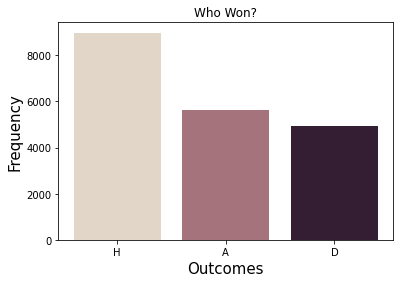

In [ ]:
wins = F.when(result_sdf.home_team_goal > result_sdf.away_team_goal, "H")\
       .otherwise(F.when(result_sdf.home_team_goal < result_sdf.away_team_goal, "A")\
                 .otherwise("D"))
result_sdf = result_sdf.withColumn("Wins", wins)
result_df = result_sdf.select("*").toPandas()

ax = sns.countplot(x="Wins", palette="ch:.25", data=result_df)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Outcomes", fontsize=15)
ax.set_title('Who Won?')
ax.plot()

## Betting Agencies

We observed that the home team are most likely to win their games followed by away teams winning. The margin between away teams winning and the outcome being a draw is much smaller than between the home team winning and away teams winning. This illustarates the concepts of home team advantage that is very popular popular in sports. Playing at home with your fans is more likely to lead to a better outcome for the team.

We then wanted to see how often do the betting agencies predict the correct outcome. Our dataset gave us the odds different betting agenices were giving for the home and away team winning and a draw for each game. We used the logic that the worse the odds we, the more likely the agency thought that team would win. This is because the worse thee odds are the less they agaency would have to pay out. 

In [ ]:
agencies  = [('B365H', 'B365D', 'B365A','B365'), ('BWH', 'BWD', 'BWA', 'BW'), ('IWH', 'IWD', 'IWA', "IW"), 
             ('LBH', 'LBD', 'LBA', 'LB'), ('WHH', 'WHD', 'WHA', 'WH'),( 'VCH', 'VCD', 'VCA', 'VC')]

for a in agencies:
    
  x = F.when((result_sdf[a[0]] < result_sdf[a[2]]) & (result_sdf[a[0]] < result_sdf[a[1]]), "H")\
  .otherwise(F.when((result_sdf[a[0]] > result_sdf[a[2]]) & (result_sdf[a[2]] < result_sdf[a[1]]), "A")\
             .otherwise("D"))
  result_sdf = result_sdf.withColumn(a[3], x)

result_df = result_sdf.select("*").toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

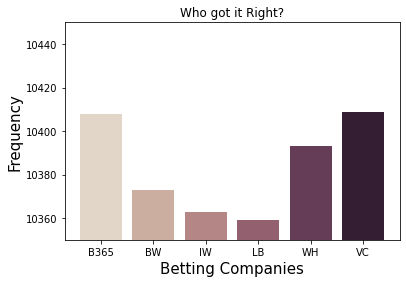

In [ ]:
y_val_best_better = []
x_val_best_better = []


result_sdf.createOrReplaceTempView("res")

for a in agencies:
  query = "SELECT * FROM res WHERE Wins={}".format(a[3]) 
  y = spark.sql(query).count()
  y_val_best_better .append(y)
  x_val_best_better.append(a[3])

ax = sns.barplot(x_val_best_better, y_val_best_better, palette="ch:.25")
plt.ylim(10350, 10450)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Betting Companies", fontsize=15)
ax.set_title('Who got it Right?')
ax.plot()

We see that the betting agencies are quite comparable in how right the are. The visulisation below shows that the betting agencies have almost have the same rate of accuracy. The agency has the worst record is only around 50 games shy of the best agency (note: y-axis).

Next we want to visualize what proprtion of games the agencies predicted outcomes correctly for. We superimposed this graph on top of the actual outcomes of the matches and found that the betting agencies predicted a bit more than half the outcomes correctly. Of the 19000~ matches played, the betting agencies predicted the correct outcomes for 10000~ of the matches.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


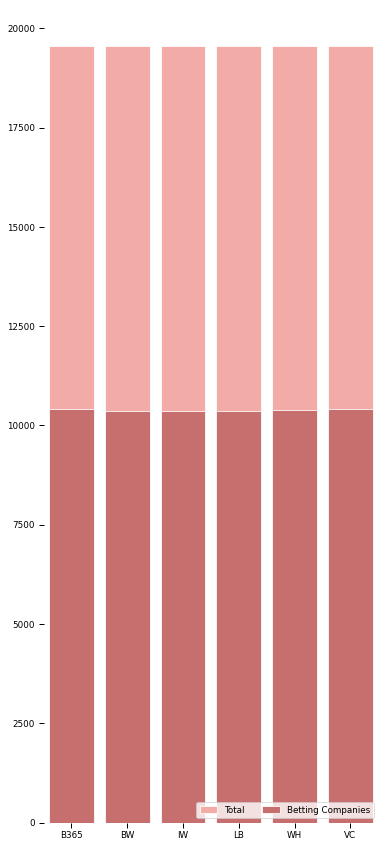

In [ ]:
sns.set_context('paper')
count = result_sdf.count()
f, ax = plt.subplots(figsize = (6,15))
sns.set_color_codes('pastel')
sns.barplot(x_val_best_better, [count, count , count, count , count, count ], label = 'Total', color = 'r', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x_val_best_better, y_val_best_better,
            label = 'Betting Companies', color = 'r', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
# plt.ylim(10350, 19600)
sns.despine(left = True, bottom = True)
plt.show()

In [ ]:
home = 0
away = 0
draw = 0
for ag in agencies:
  temp = result_sdf.groupBy(ag[3]).count()
  d = temp.collect()[0][1]
  a = temp.collect()[1][1]
  h = temp.collect()[2][1] 
  draw = draw + d
  away = away + a
  home = home + h


We then sought to observe how the betting agencies predictions regarding a home win, away win or draw compared to the actual outcomes of the games. The betting agencies prominently favoured home teams odds of winning which correlates with what we found out earlier. The red line is the sum of the betting agencies and can be read from the right y-axis. The green illustrates the avergae of the six agnecies and can be read from the same left y-axis of the bar plot.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Actual Outcomes vs Betting Companies Guess')

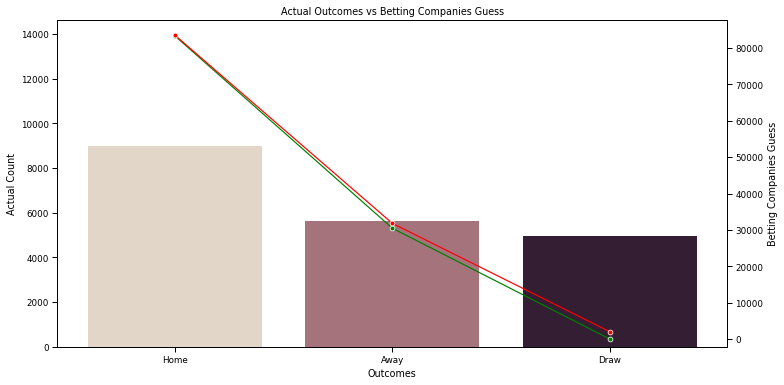

In [ ]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))
ax = sns.countplot(x="Wins", palette="ch:.25", data=result_df, ax = ax1)
sns.lineplot(["Home", "Away", "Draw"], [home/6, away/6, draw/6],color='green', marker='o', sort = False, ax= ax1)
ax.set_ylabel("Actual Count")
ax.set_xlabel("Outcomes")
ax2 = ax1.twinx()
sns.lineplot(["Home", "Away", "Draw"], [home, away, draw],color='red', marker='o', sort = False)
ax2.set_ylabel("Betting Companies Guess")

ax.set_title('Actual Outcomes vs Betting Companies Guess')

## Attributes Correlation with Win

Player and Team attributes are available before a soccer game is played. As we look to include these in our model's features, we wanted to plot the correlation between these attributes and a teams performance. This gave us insight into how our models may benefit from including them as features.

### Player Attributes

First, we sought to explore if there is a correlation between the player's attributes on a team and their performance. With the assumption that a team's performance would be related to the quality of their players.

In [ ]:
#Drop irrelevant columns and note which team won the game
drop_columns = ['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 
                'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4',
                'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8',
                'home_player_X9', 'home_player_X10', 'home_player_X11',
                'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4',
                'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8',
                'away_player_X9', 'away_player_X10', 'away_player_X11',
                'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
                'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8',
                'home_player_Y9', 'home_player_Y10', 'home_player_Y11',
                'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
                'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
                'away_player_Y9', 'away_player_Y10', 'away_player_Y11',
                'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 
                'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA']

match_winners_sdf = match_sdf.drop(*drop_columns)

match_winners_sdf = match_winners_sdf.withColumn(
    'Winner_id', 
    F.when( (match_sdf['home_team_goal']  == match_sdf['away_team_goal']) , -1)
    .otherwise(
        F.when( (match_sdf['home_team_goal'] > match_sdf['away_team_goal']) , match_sdf['home_team_api_id'])
        .otherwise(match_sdf['away_team_api_id']))) 

match_winners_sdf = match_winners_sdf.withColumn(
    'Winner', 
    F.when( (match_sdf['home_team_goal']  == match_sdf['away_team_goal']) , 'Draw')
    .otherwise(
        F.when( (match_sdf['home_team_goal'] > match_sdf['away_team_goal']) , 'Home')
        .otherwise('Away'))) 

In [ ]:
#take the average of every players attributes
avg_player_attr_sdf = player_attr_sdf.withColumn('avg_rating', (
    (sum(player_attr_sdf[col] for col in player_attr_sdf.columns if col != 'player_api_id' )) /(len(player_attr_sdf.columns)-1) )
)

avg_player_attr_sdf = avg_player_attr_sdf[['player_api_id', 'avg_rating']]

match_player_sdf = match_winners_sdf

#for each home and away player join their average onto the match_player table

home_players = ['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
                'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
                'home_player_9', 'home_player_10','home_player_11']

away_players = ['away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
                'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
                'away_player_9', 'away_player_10', 'away_player_11']

count = 1
for hp in home_players:
  match_player_sdf = match_player_sdf.alias('match').join(
    avg_player_attr_sdf.alias('player'), 
    (F.col('match.{}'.format(hp)) == F.col('player.player_api_id')),
    'left').withColumnRenamed('avg_rating', 'hp{}_avg'.format(count)
    ).drop('player_api_id')
  
  count+=1

count = 1
for ap in away_players:
  match_player_sdf = match_player_sdf.alias('match').join(
    avg_player_attr_sdf.alias('player'), 
    (F.col('match.{}'.format(ap)) == F.col('player.player_api_id')),
    'left').withColumnRenamed('avg_rating', 'ap{}_avg'.format(count)).drop('player_api_id')
  
  count+=1

In [ ]:
#for each average joined calculate the home teams average player and the away teams average player

home_players_avg = ['hp1_avg', 'hp2_avg', 'hp3_avg', 'hp4_avg', 'hp5_avg',
                    'hp6_avg', 'hp7_avg', 'hp8_avg', 'hp9_avg', 'hp10_avg',
                    'hp11_avg']

away_players_avg = ['ap1_avg', 'ap2_avg', 'ap3_avg', 'ap4_avg', 'ap5_avg',
                    'ap6_avg', 'ap7_avg', 'ap8_avg', 'ap9_avg', 'ap10_avg',
                    'ap11_avg']

match_player_sdf = match_player_sdf.withColumn('avg_hp', (
    (sum(match_player_sdf[col] for col in home_players_avg)) /(len(home_players_avg)-1) )
)

match_player_sdf = match_player_sdf.withColumn('avg_ap', (
    (sum(match_player_sdf[col] for col in away_players_avg)) /(len(home_players_avg)-1) )
)

# Note whether the team with the better average wins, loses or draws 
match_player_sdf = match_player_sdf.withColumn(
    'BetterWin', 
    F.when(( (match_player_sdf['Winner']  == 'Home') & (match_player_sdf['avg_hp'] > match_player_sdf['avg_ap']) ) , 'Win')
    .otherwise(
        F.when(( (match_player_sdf['Winner']  == 'Away') & (match_player_sdf['avg_ap'] > match_player_sdf['avg_hp']) ) , 'Win')
        .otherwise(
            F.when((match_player_sdf['Winner']  == 'Draw'), 'Draw')
            .otherwise('Loss')))) 



We found that the team with better player attributes won 50% of the time with the remainder of the distribution being essentially evenly split between a loss or draw.

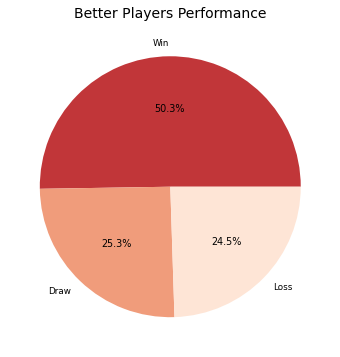

In [ ]:
data_sdf = match_player_sdf.groupBy('BetterWin').count()
data = data_sdf.toPandas()


pie, ax = plt.subplots(figsize=[10,6])
labels = ['Win', 'Draw', 'Loss']
plt.pie(data['count'], autopct="%.1f%%", labels=labels)
plt.title("Better Players Performance", fontsize=14);

### Match Attributes

We then wanted to explore if there is a correlation between the team's attributes and their performance. With the assumption that a team's performance would be related to the quality of their playing style.

In [ ]:
#reuse match_winners from above and take the average of every team's attributes
match_team_sdf = match_winners_sdf

avg_team_attr_sdf = team_attr_sdf.drop(*['id', 'team_fifa_api_id', 'date'])

avg_team_attr_sdf = avg_team_attr_sdf.groupBy('team_api_id').agg({
    'buildUpPlaySpeed':'avg', 'buildUpPlayPassing':'avg',
    'chanceCreationPassing':'avg', 'chanceCreationCrossing':'avg', 
     'chanceCreationShooting':'avg', 'defencePressure':'avg',  
     'defenceAggression':'avg', 'defenceTeamWidth':'avg',
     })

avg_team_attr_sdf = avg_team_attr_sdf.withColumn('avg_rating', (
    (sum(avg_team_attr_sdf[col] for col in avg_team_attr_sdf.columns if col != 'team_api_id' )) /(len(avg_team_attr_sdf.columns)-1) )
)

avg_team_attr_sdf = avg_team_attr_sdf[['team_api_id', 'avg_rating']]

#Join the home team and away team's atrributes onto the match_team_sdf

match_team_sdf = match_team_sdf.alias('match').join(
    avg_team_attr_sdf.alias('player'), 
    (F.col('home_team_api_id') == F.col('team_api_id')),
    'left').withColumnRenamed('avg_rating', 'ht_avg').drop('team_api_id')

match_team_sdf = match_team_sdf.alias('match').join(
    avg_team_attr_sdf.alias('player'), 
    (F.col('away_team_api_id') == F.col('team_api_id')),
    'left').withColumnRenamed('avg_rating', 'at_avg').drop('team_api_id')

match_team_sdf = match_team_sdf.withColumn(
    'BetterWin', 
    F.when(( (match_team_sdf['Winner']  == 'Home') & (match_team_sdf['ht_avg'] > match_team_sdf['at_avg']) ) , 'Win')
    .otherwise(
        F.when(( (match_team_sdf['Winner']  == 'Away') & (match_team_sdf['at_avg'] > match_team_sdf['ht_avg']) ) , 'Win')
        .otherwise(
            F.when((match_team_sdf['Winner']  == 'Draw'), 'Draw')
            .otherwise('Loss')))) 

We found that the team with better team only won 40% of the time, lost 35% of the time and drew 25% of the time. With the knowledge from the plot above we know that higher player attributes are a better indicator of a team's success than the team attributes.

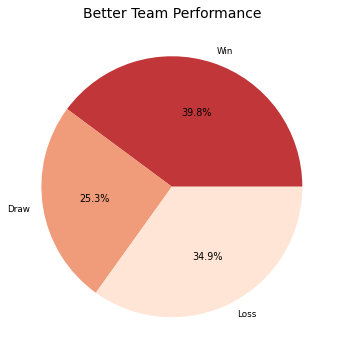

In [ ]:
data_sdf = match_team_sdf.groupBy('BetterWin').count()
data = data_sdf.toPandas()

pie, ax = plt.subplots(figsize=[10,6])
labels = ['Win', 'Draw', 'Loss']
plt.pie(data['count'], autopct="%.1f%%", labels=labels)
plt.title("Better Team Performance", fontsize=14);

# **Pre-Proccessing Data**

**In this section we readied our match data for classification modeling.** As we aim to predict the outcomes of matches we wanted all the relevant features we would use to predict our label [home, draw, away]. This code is mostly reproduced from our EDA section.

In [ ]:
#Load clean CSVs into pyspark dataframes
country_sdf = spark.read.options(header='True', inferSchema='True').csv('/content/drive/Shareddrives/FinalProject_545/Country.csv').drop('_c0')
league_sdf = spark.read.options(header='True', inferSchema='True').csv('/content/drive/Shareddrives/FinalProject_545/League.csv').drop('_c0')
match_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Match.csv").drop('_c0')
player_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Player.csv").drop('_c0')
player_attr_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Player_Attributes.csv").drop('_c0')
player_multi_attr_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Player_Multi_Atts.csv").drop('_c0')
team_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Team.csv").drop('_c0')
team_attr_sdf = spark.read.options(header='True', inferSchema='True').csv("/content/drive/Shareddrives/FinalProject_545/Clean_Team_Attributes.csv").drop('_c0')

In [ ]:
#drop irrelevant columns
data_sdf = match_sdf.drop(*
                  ['date', 'match_api_id',
                   'home_player_X1', 'home_player_X2', 'home_player_X3',
                   'home_player_X4', 'home_player_X5', 'home_player_X6',
                   'home_player_X7', 'home_player_X8', 'home_player_X9',
                   'home_player_X10', 'home_player_X11', 
                   'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
                   'home_player_Y4', 'home_player_Y5', 'home_player_Y6',
                   'home_player_Y7', 'home_player_Y8', 'home_player_Y9',
                   'home_player_Y10', 'home_player_Y11', 
                   'away_player_X1', 
                   'away_player_X2','away_player_X3','away_player_X4',
                   'away_player_X5','away_player_X6','away_player_X7',
                   'away_player_X8','away_player_X9','away_player_X10',
                   'away_player_X11',
                   'away_player_Y1','away_player_Y2', 'away_player_Y3',
                   'away_player_Y4','away_player_Y5','away_player_Y6',
                   'away_player_Y7','away_player_Y8','away_player_Y9',
                   'away_player_Y10','away_player_Y11',
                   'home_player_1', 'home_player_2', 'home_player_3',
                   'home_player_4', 'home_player_5', 'home_player_6',
                   'home_player_7', 'home_player_8', 'home_player_9',
                   'home_player_10', 'home_player_11'])

In [ ]:
#Add betting agency prediction
data_agent = data_sdf[['B365H', 'B365D', 'B365A',
                       'BWH', 'BWD', 'BWA', 
                       'IWH', 'IWD', 'IWA',
                       'LBH', 'LBD', 'LBA',
                       'WHH', 'WHD', 'WHA',
                       'VCH', 'VCD', 'VCA']]

agencies  = [('B365H', 'B365D', 'B365A','B365'), ('BWH', 'BWD', 'BWA', 'BW'), ('IWH', 'IWD', 'IWA', "IW"), 
             ('LBH', 'LBD', 'LBA', 'LB'), ('WHH', 'WHD', 'WHA', 'WH'),( 'VCH', 'VCD', 'VCA', 'VC')]
for a in agencies:
    
  x = F.when((data_agent[a[0]] < data_agent[a[2]]) & (data_agent[a[0]] < data_agent[a[1]]), "H")\
  .otherwise(F.when((data_agent[a[0]] > data_agent[a[2]]) & (data_agent[a[2]] < data_agent[a[1]]), "A").otherwise("D"))
  data_sdf = data_sdf.withColumn(a[3], x)

In [ ]:
#Add each indivual player's rating and add the rating of each team 
keep = ['id', 
        'hp1_avg', 'hp2_avg', 'hp3_avg', 'hp4_avg', 'hp5_avg', 'hp6_avg', 
        'hp7_avg', 'hp8_avg', 'hp9_avg', 'hp10_avg', 'hp11_avg',
        'ap1_avg', 'ap2_avg', 'ap3_avg', 'ap4_avg', 'ap5_avg', 'ap6_avg',
        'ap7_avg', 'ap8_avg', 'ap9_avg', 'ap10_avg', 'ap11_avg'] 
rating_sdf = match_player_sdf[keep]

data_sdf = data_sdf.alias('data').join(
    rating_sdf.alias('rating'), 
    (F.col('data.id') == F.col('rating.id')),
    'left').drop('id')

team_attr_group_sdf = team_attr_sdf.drop(*['id', 'team_fifa_api_id', 'date'])

team_attr_group_sdf = team_attr_group_sdf.groupBy('team_api_id').agg({
    'buildUpPlaySpeed':'avg', 'buildUpPlayPassing':'avg',
    'chanceCreationPassing':'avg', 'chanceCreationCrossing':'avg', 
     'chanceCreationShooting':'avg', 'defencePressure':'avg',  
     'defenceAggression':'avg', 'defenceTeamWidth':'avg',
     })


data_sdf = data_sdf.alias('data').join(
    team_attr_group_sdf.alias('team_attr'), 
    (F.col('data.home_team_api_id') == F.col('team_attr.team_api_id')), 'left'
    ).withColumnRenamed('avg(chanceCreationShooting)', 'ht_chanceCreationShooting'
    ).withColumnRenamed('avg(buildUpPlaySpeed)', 'ht_buildUpPlaySpeed'
    ).withColumnRenamed('avg(defencePressure)', 'ht_defencePressure'
    ).withColumnRenamed('avg(buildUpPlayPassing)', 'ht_buildUpPlayPassing'
    ).withColumnRenamed('avg(defenceAggression)', 'ht_defenceAggression'
    ).withColumnRenamed('avg(defenceTeamWidth)', 'ht_defenceTeamWidth'
    ).withColumnRenamed('avg(chanceCreationPassing)', 'ht_chanceCreationPassing'
    ).withColumnRenamed('avg(chanceCreationCrossing)', 'ht_chanceCreationCrossing'
    ).drop('team_api_id')

data_sdf = data_sdf.alias('data').join(
    team_attr_group_sdf.alias('team_attr'), 
    (F.col('data.away_team_api_id') == F.col('team_attr.team_api_id')), 'left'
    ).withColumnRenamed('avg(chanceCreationShooting)', 'at_chanceCreationShooting'
    ).withColumnRenamed('avg(buildUpPlaySpeed)', 'at_buildUpPlaySpeed'
    ).withColumnRenamed('avg(defencePressure)', 'at_defencePressure'
    ).withColumnRenamed('avg(buildUpPlayPassing)', 'at_buildUpPlayPassing'
    ).withColumnRenamed('avg(defenceAggression)', 'at_defenceAggression'
    ).withColumnRenamed('avg(defenceTeamWidth)', 'at_defenceTeamWidth'
    ).withColumnRenamed('avg(chanceCreationPassing)', 'at_chanceCreationPassing'
    ).withColumnRenamed('avg(chanceCreationCrossing)', 'at_chanceCreationCrossing'
    ).drop('team_api_id')

In [ ]:
#Add the label column, drop null records and convert the psypark sdf to panda df
data_sdf = data_sdf.withColumn(
    'Winner', 
    F.when( (match_sdf['home_team_goal']  == match_sdf['away_team_goal']) , 'Draw')
    .otherwise(
        F.when( (match_sdf['home_team_goal'] > match_sdf['away_team_goal']) , 'Home')
        .otherwise('Away')))

data_sdf = data_sdf.drop(*['home_team_goal', 'away_team_goal'])

count_data = data_sdf
data_sdf = data_sdf.dropna()

data = data_sdf.toPandas()

In [ ]:
#Convert categorical featueres in dataset into hot one vectors
from sklearn import preprocessing
cats = ['country_id', 'league_id', 'season', 'stage', 'home_team_api_id', 'away_team_api_id',
         'B365', 'BW', 'IW', 'LB', 'WH', 'VC']
      

for col in cats:
  data[col] = data[col].astype('category')
  colum = pd.get_dummies(data[col], prefix=col)
  data = data.drop(columns = [col])
  data = pd.concat([data, colum], axis=1)

le = preprocessing.LabelEncoder()
le.fit(["Draw", "Away", "Home"])

list(le.classes_)

le.transform(data["Winner"])  
  
data

,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA,hp1_avg,hp2_avg,hp3_avg,hp4_avg,hp5_avg,hp6_avg,hp7_avg,hp8_avg,hp9_avg,hp10_avg,hp11_avg,...,away_team_api_id_10219,away_team_api_id_10228,away_team_api_id_10229,away_team_api_id_10233,away_team_api_id_10235,away_team_api_id_10238,away_team_api_id_10242,away_team_api_id_10249,away_team_api_id_10251,away_team_api_id_10252,away_team_api_id_10260,away_team_api_id_10261,away_team_api_id_10264,away_team_api_id_10267,away_team_api_id_10268,away_team_api_id_10269,away_team_api_id_10278,away_team_api_id_10281,away_team_api_id_108893,away_team_api_id_158085,away_team_api_id_208931,away_team_api_id_274581,B365_A,B365_D,B365_H,BW_A,BW_D,BW_H,IW_A,IW_D,IW_H,LB_A,LB_D,LB_H,WH_A,WH_D,WH_H,VC_A,VC_D,VC_H
0,104378.0,38337.0,38255.0,12473.0,104382.0,33662.0,41109.0,166618.0,38233.0,12574.0,46335.0,1.57,3.6,5.50,1.70,3.4,4.50,1.60,3.4,4.60,1.57,3.50,5.00,1.50,3.50,6.00,1.70,3.4,4.33,44.624224,52.864719,53.617560,60.529762,48.621429,61.042582,60.155220,60.934363,57.879202,54.938095,57.784799,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
1,104378.0,28133.0,71765.0,36832.0,42594.0,31294.0,14557.0,38336.0,113868.0,38366.0,33657.0,6.00,3.8,1.57,5.25,3.8,1.60,4.50,3.3,1.65,5.00,3.50,1.57,4.80,3.75,1.62,6.00,4.2,1.53,38.142857,44.066327,54.219156,44.621032,42.261905,51.146104,53.155462,58.813988,50.949675,50.120536,44.726190,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,91929.0,92527.0,148314.0,109331.0,166675.0,32863.0,130027.0,37112.0,42153.0,38782.0,148315.0,3.80,3.6,1.91,3.50,3.6,1.87,3.50,3.3,1.90,3.50,3.50,1.91,3.50,3.40,1.95,3.80,3.7,1.90,44.489496,49.020833,51.952381,44.066327,45.903061,55.295455,53.795918,49.092262,58.813988,44.726190,50.800824,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,208699.0,38339.0,8930.0,98368.0,26606.0,37963.0,104411.0,104410.0,32760.0,78902.0,80592.0,1.91,3.4,4.00,1.95,3.1,3.80,1.90,3.2,3.60,1.90,3.25,4.00,2.00,3.30,3.50,1.95,3.4,4.10,33.752232,44.521429,41.642857,45.011905,54.163866,49.559524,53.508403,55.824405,52.878571,47.738636,53.492857,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
4,346114.0,538333.0,27412.0,95904.0,179241.0,212598.0,130027.0,38323.0,68120.0,42706.0,107983.0,1.65,3.6,5.50,1.70,3.5,5.00,1.70,3.6,4.70,1.70,3.50,5.25,1.70,3.40,4.80,1.65,3.7,5.40,40.977444,54.653439,49.500000,52.438312,53.855357,52.740683,56.116071,51.607143,49.584184,50.735119,52.598901,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19475,183348.0,79737.0,97486.0,41166.0,154938.0,33586.0,183346.0,75376.0,25347.0,41168.0,111975.0,2.20,3.3,3.25,2.30,3.2,3.10,2.30,3.3,2.90,2.30,3.40,3.00,2.30,3.30,3.10,2.38,3.4,3.12,39.625000,53.796429,59.161905,50.774436,55.192547,52.908929,57.630102,56.996753,51.913961,58.364618,56.716270,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
19476,104986.0,21450.0,33607.0,191906.0,72542.0,231811.0,50027.0,183350.0,38886.0,18784.0,108809.0,2.00,3.4,3.75,1.95,3.3,4.00,2.00,3.3,3.60,1.90,3.50,3.80,2.05,3.20,3.80,2.00,3.6,4.00,43.087143,58.052910,52.728111,50.835404,61.785714,59.271429,55.535714,58.383459,61.088670,57.927143,55.617560,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
19477,33845.0,33634.0,75397.0,37479.0,46391.0,38431.0,78404.0,75192.0,24383.0,37461.0,40203.0,1.44,4.2,7.50,1.50

# **Machine Learning Models**

**In this section we attempt to see whether we can train a classification model to outperform our betting agencies.**

We first split our data into features and labels. We are trying to predict who will win a given game based on the ratings of the players, team qualities and the betting odds of other agencies. We also had to transform our labels into numeric encodings using LabelEncoding to use in our Random Forest Model. Using it for other models did not change the accuracy of them so we chose to use the transformed version for all of the models we tried.

In [ ]:
label = data['Winner']
features = data.drop(['Winner'], 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2)
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

We decided to start with a Support Vector Classifier (SVC) model. This a very well know Support Vectorization machine (SVM). We found that the accuracy with no hyperparameter tuning was ~45%. This seemed to be a good result as the betting agencies provided performed similarly. 




In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# look into min-max scaling 

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
clt = SVC()
clt.fit(x_train, y_train)
y_pred = clt.predict(x_test)

accuracy = clt.score(x_test, y_test)

print(accuracy)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

0.46149897330595485
              precision    recall  f1-score   support

           0       0.33      0.00      0.00      1114
           1       0.00      0.00      0.00       983
           2       0.46      1.00      0.63      1799

    accuracy                           0.46      3896
   macro avg       0.27      0.33      0.21      3896
weighted avg       0.31      0.46      0.29      3896

[[   1    1 1112]
 [   1    0  982]
 [   1    1 1797]]


We found that our model seemed to be running for quite a long time so we chose to use Principal Component Analysis to reduce number of dimensions of the dataset, we plotted the explained_variance_ratio against the number of components to decide the number of components you should keep. We found that keeping 10 components captured most of the data's variance 

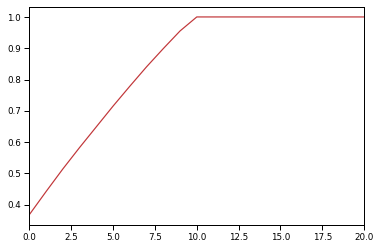

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
# Your code goes here
pca = PCA()
# standardscaler.fit_transform
x_pca = pca.fit(x_train)
explained_variance = pca.explained_variance_ratio_


# use line graph
# cummulitavesum cumsum
plt.figure()
plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.xlim(0, 20)
plt.show()

In [ ]:
pca = PCA(n_components=10)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

We chose to perform a Grid Search to see if we could find better hyperparameters to improve the accuracy of our model. We chose to find values for two parameters : C and gamma as they are commonly hypertuned parameters.

https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/


The defualt values we used in our first model were C: 1.0 and gamma = 1/(n_features * x_train.var()). Thus, we chose to scale them in search of better parameters

In [ ]:
n_features = x_train.shape[1]
gamma = 1/(n_features * x_train.var())
print(gamma)
exp6 = 10**6 * gamma
exp18 = 10**-6 * gamma

8.223725020889761e-12


We found the best parameter values were C: 0.1 and gamma: 8.3e-06 with an accuracy of ~46%. This is only a percent better than our default parameters, suggesting that we chose poor alternatives or our model may not benefit from further hypertuning.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10], 'gamma': [exp6, gamma, exp18]}
grid = GridSearchCV(SVC(), param_grid, n_jobs=2)
grid_results = grid.fit(x_train,y_train)
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

Best: 0.4568788576290606, using {'C': 0.1, 'gamma': 8.223725020889761e-06}


We then re-ran our model with our PCA transforms of training and test features. We also used the debatebly better paramters we found. We found that the accuracy was only ~47%. 

Thus, our SVC model performed as well before our PCA transformations or hypertuning.

In [ ]:
clt = SVC(C=0.1, gamma=8.267739990064859e-06)
clt.fit( x_train, y_train)
y_pred = clt.predict(x_test)

accuracy = clt.score(x_test, y_test)

print(accuracy)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

0.4681724845995893
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1136
           1       0.00      0.00      0.00       936
           2       0.47      1.00      0.64      1824

    accuracy                           0.47      3896
   macro avg       0.16      0.33      0.21      3896
weighted avg       0.22      0.47      0.30      3896

[[   0    0 1136]
 [   0    0  936]
 [   0    0 1824]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We then ran a LinearSVC. Though both are housed in the SVM library, one of the biggest differences between a SVC model and a liner SVC model is that LinearSVC models minimize the squared hinge loss while SVC minimizes the regular hinge loss.
In our research for choosing models we saw that a LinearSVC model marginally performs better than an SVC model.

However, it was actually the opposite in our case as our LinearSVC had an accuracy of ~32% far less than the 45% our SVC had. The non-linear rbf kernel our SVC uses suggests that our data might be poorly linearly separable and subsequently, performs worse with a LinearSVC.

https://stackoverflow.com/questions/45384185/what-is-the-difference-between-linearsvc-and-svckernel-linear

In [ ]:
from sklearn.svm import LinearSVC
clt = LinearSVC(penalty='l2')
clt.fit( x_train, y_train)
y_pred = clt.predict(x_test)

accuracy = clt.score(x_test, y_test)

print(accuracy)

0.3228952772073922


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We then chose to implement SGDClassfier which uses gradient descent and the best coefficients are found during the iteration process. 

SVCs use the full data and solve a convex optimization problem while SGD performs a gradient descent trying to minimize expected loss.

SGD is said to perform better with a larger dataset so we thought it would perform better. 

However, we found that it wasn't true, for our SGD model only performed with ~33% accuracy far less than the 45% of our SVC model.

https://stackoverflow.com/questions/29704231/in-sklearn-what-is-the-difference-between-a-svm-model-with-linear-kernel-and-a-s

https://stackoverflow.com/questions/48022187/scikit-learn-what-is-the-difference-between-svc-and-sgd


In [ ]:
from sklearn import linear_model

SGDClf = linear_model.SGDClassifier(max_iter = 1000, tol=1e-3,penalty = "elasticnet")
SGDClf.fit(x_train, y_train)
y_pred  = SGDClf.predict(x_test)
accuracy = SGDClf.score(x_test, y_test)

print(accuracy)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

0.3336755646817248
              precision    recall  f1-score   support

           0       0.30      0.53      0.38      1136
           1       0.21      0.16      0.18       936
           2       0.47      0.30      0.37      1824

    accuracy                           0.33      3896
   macro avg       0.33      0.33      0.31      3896
weighted avg       0.36      0.33      0.33      3896

[[604 199 333]
 [512 151 273]
 [913 366 545]]


We also modeled our data with Random Forest Classifier. Random Forest is more suitable for mulitclass problems as in our data we have three possible prediction labels - away, home, draw. 

As Random Forest works well with a mixture of numerical and categorical features which our features do consist of we thought it may outpeform our SVC model. However, we found that the random forest performed comparably (~43%) to our SVC (45%).
  

https://datascience.stackexchange.com/questions/6838/when-to-use-random-forest-over-svm-and-vice-versa

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
accuracy = rf_model.score(x_test, y_test)

print(accuracy)

0.436088295687885


When the training data is much larger than the number of features, K-nearest neighbours (KNN) is better than SVM. With 10 features and ~19000 records we thought that a KNN model may outperform our SVC SVM. Additionally, it has few hyperparameters to tune.

However, our SVC (45%) outperformed our KNN model (~37%) showing that our number of records did not exceed our features to the point where a KNN model would be better.

https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
accuracy = knn_model.score(x_test, y_test)

print(accuracy)

0.37705338809034905


# **Conclusion**

After modelling our data with these different models, our best attempt performed comparably to the betting agencies we had. What this shows is the additional features about the players and matches we included didn't give us an edge over the betting agencies. This could mean that we would have to research other features about the football games, teams and players to see if we can find more instrumental features that can help. Several thing we could consider is the quality of the club managers, winning streaks and ticket sales.  

Another big part of betting on sports is having predictions about player performances. We could also expand this project and use the information we have about the players, and more information we find to help predict their performances. This may potentially serve as a feature we could use to improve our models.  

We will also have to learn more about models to understand how best we can utilize them. Due to the runtime of the GridSearchCV trying different kernels (+5hrs) was too inefficient and we were unable to determine whether rbf was indeed the best kernel to use. Our best performing model (SVC) has ample parameters, and understanding them better could help us improve the performance of our model.